# Exercise 5: the formation of molecular oxygen using molecular orbital theory

This exercise examines the formation of **triplet oxygen**, the most stable and most common allotropic form of O$_2$. Triplet oxygen has two electrons in its two **degenerate** (i.e., having the same energy, or, more formally, two distinct microstates corresponding to the same macrostate) $\pi^*$ orbitals. There are four independent spin states arising from these two spin-1/2 electrons, and so there are a total of $\binom{4}{2}=6$ possible ways (microstates) to arrange the two electrons into the two degenerate $\pi^*$ orbitals. Here, we will only consider the triply-degenerate ground state: according to **Hund's rules**, the configuration with two unpaired electrons in two $\pi^*$ orbitals is energetically favoured.

In the following, you will generate a [molecular orbital schema](https://en.wikipedia.org/wiki/Triplet_oxygen#/media/File:Valence_orbitals_of_oxygen_atom_and_dioxygen_molecule_(diagram).svg) for triplet oxygen, that is, the configuration for which the total spin equals 1.

## 1. Introduction

Log into your account on `JupyterHub` in a similar manner as described in previous exercises, and `pull` the newest exercise files from the GitHub repository:
```bash
    $ git init
  # $ git stash
    $ git pull https://github.com/ramador09/Molecular-and-Materials-Modelling-FS2023.git
    $ cd exercise-6_files
```
## 2. The triplet molecule
### 2.1 The input file: a closer look

Move into the directory for the triplet molecule and open the input file. There is some new syntax in the input file, including use of the `@`, `$`, and `{}`characters. We will go through them briefly here as well as live in the exercise:

* `@`: in the combination `@SET`, this command at the beginning of an input file allows us to define variables which we will reference later in the input file
* `$`: syntax inherited from Unix: used to indicate that a variable will be referred to; requires curly braces `{}` afterwards
* `{}`: encloses the name of a variable to be referred to

This syntax is best illustrated by perusing the input file. Furthermore, the lines 

```
&E_DENSITY_CUBE
&END E_DENSITY_CUBE
NLUMO 1
NHOMO 1
```
in the `&PRINT` subsection in `&DFT` will generate the files that we will use for this exercise.

The submit script (almost identical to that of exercise 3) is:

```
#!/bin/bash

#SBATCH -N 1
#SBATCH -n 1
#SBATCH --time=4:00:00
#SBATCH --job-name="nice name"
#SBATCH --mem-per-cpu=1024
#SBATCH --output=stdout.txt
#SBATCH --error=stderr.txt

# module load openmpi/4.0.2
# module load gcc/6.3.0 openmpi/4.0.2 cp2k/8.2
INP=triplet.inp
OUT=triplet.out
/cluster/scratch/danielep/cp2k.ssmp -i triplet.inp > triplet.out
```

Make sure the input file and submit script are in the same directory and submit the geometry optimization; it shouldn't take so long to run. Import some necessary packages and libraries by executing the following cell:

In [1]:
from ase.visualize import view
from ase.io import read
import nglview as nv

### 2.2: visualization of the electronic density

Once the job has concluded, open one of the `.cube` output files. These types of files are used by CP2K and many other electronic structure programs to store spin, orbital, or electronic density values on a three-dimensional grid. Some good documentation can be found [here](https://h5cube-spec.readthedocs.io/en/latest/cubeformat.html) and [here](https://manual.q-chem.com/5.3/sec_cubefiles.html).

**Due to a bug, it is imperative that you copy your `.cube` files to your `/tmp/` directory and access them from there, as in the example, and NOT use them directly in the output directory:**

In [2]:
!cp triplet_mol/o2*.cube /tmp

In [30]:
file = '/tmp/o2-ELECTRON_DENSITY-1_0.cube'
atoms = read(file)

view = nv.NGLWidget()
view.add_component(nv.ASEStructure(atoms))

c_2 = view.add_component(file)
c_2.clear()
c_2.add_surface(color='blue', isolevelType="value", isolevel=-0.005, opacity=0.05)

c_3=view.add_component(file)
c_3.clear()
c_3.add_surface(color='green', isolevelType="value", isolevel=0.015, opacity=0.15)

view
print("hey")

NGLWidget()

**!! Note: in this case as in the rest of the exercise, you might need to play around a bit with the values of the `isolevel` parameter. In general, both values should be quite small (ie absolute values close to zero), with one being negative and one being positive. !!**

### 2.3: Computing density differences

This however is just the electronic density of the oxygen molecule: what is probably more interesting, are density *differences*. In order to compute these differences, we use a tool called [cubecruncher](https://github.com/cp2k/cp2k/tree/master/tools/cubecruncher), which allows us to perform various operations on cube files -- notably subtraction.

Our goal is to obtain the density difference, and as such, we must subtract off the electron densities of each of the individual (!) oxygen atoms. To do this, we run two more simulations (ie, one for each of the individual atoms), whereby each simulation will generate the electron density (in turn, contained in its respective cube file) of that respective oxygen atom.

1. We proceed by making a new directory within the current one: `$ mkdir diffs`
2. Move into the `diffs` directory and copy the full electron density from the foregoing calculation into the `diffs` directory; give it a more suitable name if it helps:
```bash
$ cd diffs
$ cp ../o2_trip-ELECTRON_DENSITY-1_0.cube ./full.cube
```
3. We now need to run the same simulation as for the molecule, except now for each of the individual two oxygen atoms. Let's make two new directories to contain these new simulations, and we copy the input file and run script from the parent calculation into these new directories:

```bash
$ mkdir o1
$ mkdir o2
$ cp ../{triplet.inp,submit.sh} o1
$ cp ../{triplet.inp,submit.sh} o2
```

4. Move into the `o1` directory and remove the atom labeled `O2`:

```
    &COORD [angstrom]
  O1         6.2069331992        6.2068856913        5.6293948156
  O2         6.2068666902        6.2069143409        6.7844056115 #REMOVE
    &END COORD
```

and its associated `&KIND` a few lines later:

```
    &KIND O2 #REMOVE ALL THIS
       MAGNETIZATION 0
       ELEMENT O
       BASIS_SET aug-cc-pVTZ
       POTENTIAL ALL
   &END KIND
```

5. For bookkeeping's sake, change the name of the project:
```
PROJECT o1
```
and save and quit the file.

6. For bookkeeping's sake, it might not be a bad idea to change the name of the input file itself. Don't forget to adjust anything in the submit script accordingly. Once everything is good, submit the job.

7. Repeat steps 4-6 for o2.

8. Copy (or move) the electron density files from each of the individual atoms into the `diff` directory (your relative paths might be a bit different depending on which directory exactly you're currently in):
```bash
$ cp o1/o1-ELECTRON_DENSITY-1_0.cube ./o1.cube
$ cp o2/o2-ELECTRON_DENSITY-1_0.cube ./o2.cube
```

9. Now we have the three files --- `full.cube, o1.cube, o2.cube` --- which we'll need to plot the density differences. Let's first take `full.cube` minus `o1.cube` and save this temporary difference to a file `temp.diff`:
```bash
$ /cluster/scratch/danielep/cubecruncher.x -i full.cube -o temp.cube -subtract o1.cube
```

10. Now we subtract `o2.cube` from `temp.cube` and store the desired difference file to `diff.cube`:
```bash
$ /cluster/scratch/danielep/cubecruncher.x -i temp.cube -o diff.cube -subtract o2.cube
```

### Assignment 1: Visualizing the electronic density difference

Use the code of a few cells above (modify as necessary) to visualize the `diff.cube` file. Comment on how it differences from the first plot.

In [3]:
!cp triplet_mol/diffs/diff.cube $SCRATCH/tmp

In [8]:
file2 = '/cluster/scratch/jbachmann/tmp/diff.cube'
atoms2 = read(file2)

view2 = nv.NGLWidget()
view2.add_component(nv.ASEStructure(atoms2))

c_4 = view2.add_component(file2)
c_4.clear()
c_4.add_surface(color='blue', isolevelType="value", isolevel=-0.005, opacity=0.05)

c_5=view2.add_component(file2)
c_5.clear()
c_5.add_surface(color='green', isolevelType="value", isolevel=0.005, opacity=0.05)

view2

NGLWidget()

**!! NOTE: Your result might not be "displaying as expected" (like it was with me). To remedy this, restart your kernel (Kernel -> Shut Down All Kernels) and restart your server. !!**

### End Assignment 1

### Assignment 2: Visualizing the molecular orbitals

You will have certainly noticed the plethora of `WFN_000xyz_a-b_c.cube` files generated as a result of the calculation. These are the HOMO-$\eta$ and LUMO+$\xi$ orbitals, where the values of $\eta$ and $\xi$ were specified in the `.inp` file, respectively. 

1. The first subtask of this assignment will simply involve decoding the names of these files, and assigning them to the respective molecular orbital (HOMO-3, LUMO+2, etc.) to which they belong. Open one of these `WFN_000xyz_a-b_c.cube` files and observe how the first two lines (which are indeed always **comment** lines in `.cube` files) look like (for the `o2-WFN_00001_1-1_0.cube` file):

```
-Quickstep-
  WAVEFUNCTION            1  spin            1  i.e. HOMO -           -8
```

Write a script, either in Python or in Bash, that takes the "informational part" of the file name,  extracts the data of the second comment line, and writes this information to a `.txt` file. The script should loop through all the `WFN` files in the current directory. This `.txt` file will be your reference for the remainder of this exercise. If you do it in Python, you might need the `sys` and/or `os` libraries; if you do it in Bash, you'll surely need `grep`. In any case, completion of this subtask will involve some string manipulation. The `.txt` file might look like something similar to this:

```
file wavefunction spin orbital
00001_1-1_0 1 1 HOMO-8
...
```

Of course, it doesn't *have* to look like *exactly* like this, but a format similar to the above might be helpful.

2. Now that we've got a correspondence between these "cryptic" `WFN.cube` files and the orbitals they contain, we can plot them. Using the `.txt` file you generated in subtask 1 as a reference (so that you know exactly what files to plot), plot all of the occupied orbitals and the first 3 or 4 unoccupied orbitals. 

In [4]:
# your code here

import pandas as pd

In [5]:

def plot_wave_func(df, kind, orbital):
    df = df.sort_values("orbital")
    occupied = df.loc[df["orbital"].str.contains("HOMO")]
    unoccupied = df.loc[df["orbital"].str.contains("LUMO")]

    if kind == "HOMO":
        rows = occupied.loc[occupied["orbital"].str.contains(f"{orbital}")]
        isolevel = 1e-5
    elif kind == "LUMO":
        uq = unoccupied["orbital"].unique()
        rows = unoccupied.loc[unoccupied["orbital"].str.contains(uq[orbital])]
        isolevel = 1e-3
    else:
        raise ValueError
    
    print(rows)
    colors = [["darkblue", "green"], ["blue", "lightgreen"]]
    spins = ["up", "down"]
    
    view3 = nv.NGLWidget()
    
    for index, row in rows.iterrows():
        spin = row["spin"] - 1
        print(f"spin {spins[spin]}:", colors[spin])
        file = f"/tmp/{row['file']}"
        atom = read(file)
        view3.add_component(nv.ASEStructure(atom))
        c_4 = view3.add_component(file)
        c_4.clear()
        c_4.add_surface(color=colors[row["spin"]-1][0], isolevelType="value", isolevel=-isolevel, opacity=0.05)    
        c_5 = view3.add_component(file)
        c_5.clear()
        c_5.add_surface(color=colors[row["spin"]-1][1], isolevelType="value", isolevel=isolevel, opacity=0.05)    
    return view3


The above code plotts the wave function orbitals for all present electrons for a given HOMO$-\eta$ ar LUMO$+\xi$ orbitals.

I.e. calling `plot_wave_func(df, "HOMO", 2)` will plot the spin up and spin down (if present) electron for the HOMO$-2$ orbital, where df is the file giving the correspondence between files and orbitals from the task above.

In [6]:
names = "triplet_mol/names.txt"
df = pd.read_csv(names, sep=" ")

plot_wave_func(df, "HOMO", 2)

                       file  wavefunction  spin orbital
9   o2-WFN_00005_2-1_0.cube             5     2  HOMO-2
12  o2-WFN_00007_1-1_0.cube             7     1  HOMO-2
spin down: ['blue', 'lightgreen']
spin up: ['darkblue', 'green']


NGLWidget()

### Assignment 3: the triplet atom

1. Move into the directory `triplet_atom` and run the same calculation (singular!) now for the single oxygen atom. Visualize the eletron density `ELECTRON_DENSITY-1_0.cube`. Comment on the important differences between the plot of the electron density.

2. Plot all of the orbitals and comment on the difference. Note that the text "HOMO", "LUMO" in the context of the single oxygen atom is, strictly taken, not so correct, since these are purely atomic orbitals. What do you notice about the differences between the atomic orbitals and the molecular orbitals at the same level?

In [7]:
### your code here
!cp triplet_atom/o-WFN*.cube /tmp

In [122]:
names = "triplet_atom/names.txt"
df = pd.read_csv(names, sep=" ")

plot_wave_func(df, "LUMO", 0)

                      file  wavefunction  spin orbital
7   o-WFN_00004_2-1_0.cube             4     2   LUMO0
10  o-WFN_00006_1-1_0.cube             6     1   LUMO0
spin down: ['blue', 'lightgreen']
spin up: ['darkblue', 'green']


NGLWidget()

### End Assignment 3

## 3. ~~Reading~~ Interpreting the output files.

Before concluding today's exercise, there are two pieces of information that we should be made aware of, which can be found towards the end of the respective `.out` files. Open the `triplet.out` file for the molecule and scroll towards the bottom until you find

```
  Eigenvalues of the occupied subspace spin            1
 ---------------------------------------------
     -18.91106343     -18.91098286      -1.20199960      -0.75825075
      -0.49784172      -0.49451467      -0.49451467      -0.25446183
      -0.25446183
 Fermi Energy [eV] :   -6.924259
  
  Eigenvalues of the occupied subspace spin            2
 ---------------------------------------------
     -18.88507991     -18.88499208      -1.15811454      -0.69227713
      -0.46456304      -0.42601125      -0.42601125
 Fermi Energy [eV] :  -11.592356
```

Even though we didn't plot and visualize the spin densities explicitly, we should note that we have indeed calculated them (see the output files). The table of `Eigenvalues of the occupied subspace spin` shows exactly the spin-splitting phenomenon that we expect from the molecular orbital schema of oxygen; the `1` resp. `2` indicates the spin up and spin down. 

### Assignment 4: extraction of the energies and construction of the MO schema

Use the values of the energy from the output files of the calculations from both the triplet molecule and the triplet atom to generate an ordering of the energies. Similar to [this figure](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Physical_Chemistry_(LibreTexts)/09%3A_Chemical_Bonding_in_Diatomic_Molecules/9.10%3A_Molecular_Orbital_Theory_Predicts_that_Molecular_Oxygen_is_Paramagnetic), energy should be on the vertical axis. Your plot can be as sophisticated or as simple as you like, but should contain all of the following information:
* show the degeneracy in energy between distinct states (ie, that the two 2s states have the same energy and the two 2p states have the same energy, although the latter corresponds to a different (microstate!) spin configuration);
* show the molecular orbital splitting between the $s$ resp. $p$ orbitals;
* show the respective spin configuration of each shell (up resp. down);
* contain all necessary labels
* use what was learned in class to explain why molecular oxygen is paramagnetic



In [8]:
### your code here
mol_spin_up = np.array([-20.76157671, -20.76095076, -1.70890511, -1.21356831, -0.84116479, -0.84116479, -0.76348818, -0.56457473, -0.56457473])
mol_spin_down = np.array([-20.70654391, -20.70540302, -1.57563480, -1.00019707, -0.70279623, -0.57250023, -0.57250023])
atom_spin_up = np.array([-20.71085736, -1.41958723, -0.71103451, -0.71103029, -0.61185840])
atom_spin_down = np.array([-20.63236456, -1.07732143, -0.52185147])

mol_spin_up_reference = np.array([-18.91106343, -18.91098286, -1.20199960, -0.75825075, -0.49784172, -0.49451467, -0.49451467, -0.25446183, -0.25446183])
mol_spin_down_reference = np.array([-18.88507991, -18.88499208, -1.15811454, -0.69227713, -0.46456304, -0.42601125, -0.42601125])

In [58]:
import matplotlib.pyplot as plt
import numpy as np

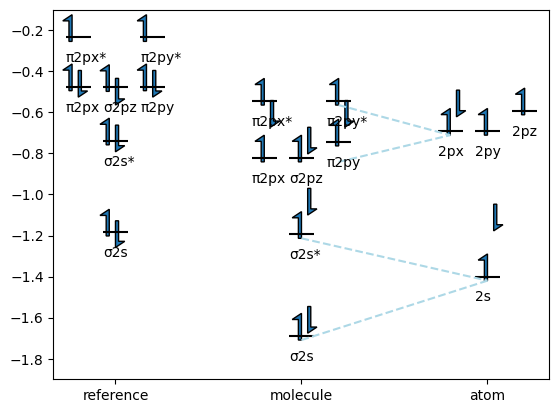

In [121]:
style = {"head_width": 0.003, "head_length":0.03, "shape": "right"}
dy = 0.1
offset = style["head_length"]

def to_plot(eigen_values):
    return np.array([i for i in eigen_values if i > -5])

offset_degen = 0.006
orbitals_x = np.array([0, 0, 0, -offset_degen, offset_degen, -offset_degen, offset_degen, 0])
orbitals_x_at = np.array([0, -offset_degen, 0, offset_degen])

def plot_mo(eig, spin, orb_x, dx):
    eig = to_plot(eig)
    length = eig.shape[0]
    if spin == 1:
        for i in range(length):
            plt.arrow(dx + orb_x[i], eig[i], 0, dy, **style)
    if spin == 2:
        for i in range(length):
            plt.arrow(dx + orb_x[i], offset + eig[i], 0, -dy, **style)


dx = 0.001
molx = 0
atx = 0.03
refx = -0.03
        
plot_mo(mol_spin_up, 1, orbitals_x, molx)
plot_mo(mol_spin_down, 2, orbitals_x, molx + dx)

plot_mo(atom_spin_up, 1, orbitals_x_at, atx)
plot_mo(atom_spin_down, 2, orbitals_x_at, atx + dx)

plot_mo(mol_spin_up_reference, 1, orbitals_x, refx - dx)
plot_mo(mol_spin_down_reference, 2, orbitals_x, refx)

orbitals_mol = ["σ2s", "σ2s*", "σ2pz", "π2px", "π2py", "π2px*", "π2py*", "σ2pz*"]
orbitals_at = ["2s", "2px", "2py", "2pz"]

def label_levels(eig, x, orb, orbx):
    for i, e in enumerate(to_plot(eig)):
        plt.hlines(y=e + 0.02, xmin=x -2*dx + orbx[i], xmax=x + 2*dx + orbx[i], color="black")
        plt.text(x - 2*dx + orbx[i], e - 0.1, orb[i])
    
label_levels(mol_spin_up_reference, refx, orbitals_mol, orbitals_x)
label_levels(mol_spin_up, molx, orbitals_mol, orbitals_x)
label_levels(atom_spin_up, atx, orbitals_at, orbitals_x_at)

# Plot the splitting
# s-orbital
plt.plot([molx, atx], [mol_spin_up[2], atom_spin_up[1]], linestyle="dashed", color="lightblue")
plt.plot([molx, atx], [mol_spin_up[3], atom_spin_up[1]], linestyle="dashed", color="lightblue")
# p-orbitals
plt.plot([molx + offset_degen, atx - offset_degen], [mol_spin_up[4], atom_spin_up[2]], linestyle="dashed", color="lightblue")
plt.plot([molx + offset_degen, atx - offset_degen], [mol_spin_up[7], atom_spin_up[2]], linestyle="dashed", color="lightblue")


plt.xticks([refx, molx, atx], ["reference", "molecule", "atom"])


plt.xlim([-0.04, 0.04])
plt.ylim([-1.9, -0.1])
plt.show()

The "reference" plot is with the values given in the exercise, the "molecule" and "atom" are from my calculations.

The referece values have been taken, because the values obtained from my simulations are not accurate enough (probably because of the hartee-fock approximation).

The 1s orbitals are not plotted, because they are far away and the interesting information about the 2s and 2p orbitals would be lost.

In the "atom" plot, where the orbitals af a single atom are, one can nicely see the degeneracy of the p-orbitals (up to some errors). 
When comparing to the "molecule", we can see a nice splitting of the 2s orbitals into binding and antibinding $\sigma 2s^{(*)}$ orbitals (indicated by the dashed lines). 
And also the 2p orbitals are splitted into binding and antibinding $\pi p_{x, y}^{(*)}$ and $\sigma p_z^{(*)}$ orbitals. 
Note that the antibinding $\sigma p_z^{*}$ orbital is not present, because it's not yet occupied.

The reason why I have also plotted the reference values, can bee seen in the plots. The down spin atoms tend to have a higher eigen energy value as they should,
and hence we do not clearly see, whether the two antibinding $\pi_x^*$ prbitals are twice occupied or only once in the "molecule" plot. 
Additionally, all the eigen energies seem to be slighly higher than my computed ones.

From the reference values, its clear, that the $\pi p_x^{*}$ and $\pi p_{y}^{*}$ orbitals are only single occupied and hence there are two unpaired electrons. And hence by definition, $O_2$ is paramagnetic.

### End Assignment 4